Import libraries

In [1]:
import pandas as pd
from pmdarima import auto_arima
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.statespace.sarimax import SARIMAX
import sys
from pathlib import Path

# Get the parent directory
parent_dir = Path.cwd().parent.parent

# Ensure it's not already in sys.path
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))
from shared.metrics import print_evaluation_metrics
from shared.helpers import store_model

Load dataset and prepare df

In [2]:
file_path = "../data/parsed_dataset.csv"
date_column = "Date_reported"
target_column = "New_deaths"
df = pd.read_csv(file_path, parse_dates=True)
df = df[[date_column, target_column]]

df = df.groupby(date_column).sum().reset_index()
df.set_index(date_column, inplace=True)
df = df.dropna()
dates = df.index.values

Train test split

In [3]:
data_length = len(df)
train_split = 0.9
train = df.iloc[:int(data_length*train_split)]
test = df.iloc[int(data_length*train_split):]

Parameter tuning for order and seasonal order

In [4]:
stepwise_fit = auto_arima(
    df[target_column],
    trace=True,
    suppress_warnings=True,
    max_P=3,
    max_D=2,
    max_Q=3,
    m=12,
    stepwise=True,
)
best_order = stepwise_fit.order
best_seasonal_order = stepwise_fit.seasonal_order

Performing stepwise search to minimize aic


 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=25380.343, Time=14.10 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=26399.060, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=25895.379, Time=1.00 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=25501.119, Time=6.84 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=26397.060, Time=0.06 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=25390.044, Time=11.22 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=inf, Time=12.27 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=26790.651, Time=19.70 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=26086.365, Time=31.64 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=25434.630, Time=4.53 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=25248.180, Time=26.04 sec
 ARIMA(2,1,2)(0,0,3)[12] intercept   : AIC=inf, Time=51.35 sec
 ARIMA(2,1,2)(1,0,3)[12] intercept   : AIC=inf, Time=50.34 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=25327.265, Time=22.11 sec
 ARIMA(2,1,1)(0,0,2)[12] intercept   : AIC=25367.373, Tim

In [5]:
print(best_order)
print(best_seasonal_order)

(2, 1, 3)
(0, 0, 2, 12)


Create Model

In [6]:
model = SARIMAX(
    train[target_column], order=(4, 1, 2), seasonal_order=(1, 0, 1, 12)
)
model = model.fit()
model.summary()

/home/samuell/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/samuell/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/samuell/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/samuell/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17974D+01    |proj g|=  3.78707D+00


 This problem is unconstrained.



At iterate    5    f=  9.69663D+00    |proj g|=  4.30480D-01

At iterate   10    f=  9.42979D+00    |proj g|=  2.79793D-01

At iterate   15    f=  9.35033D+00    |proj g|=  9.45785D-02

At iterate   20    f=  9.33891D+00    |proj g|=  7.38976D-03

At iterate   25    f=  9.33887D+00    |proj g|=  3.39924D-03

At iterate   30    f=  9.33851D+00    |proj g|=  2.25136D-02

At iterate   35    f=  9.29587D+00    |proj g|=  1.42477D-01

At iterate   40    f=  9.06265D+00    |proj g|=  2.10891D-01

At iterate   45    f=  9.03510D+00    |proj g|=  1.21394D-02

At iterate   50    f=  9.03493D+00    |proj g|=  5.66384D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/samuell/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           New_deaths   No. Observations:                 1251
Model:             SARIMAX(4, 1, 2)x(1, 0, [1], 12)   Log Likelihood              -11302.695
Date:                              Sat, 13 Apr 2024   AIC                          22623.389
Time:                                      21:02:33   BIC                          22669.568
Sample:                                  02-02-2020   HQIC                         22640.749
                                       - 07-06-2023                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8809      0.026    -33.370      0.000      -0.933      -0.829
ar.L2         -0.0414      0.037     -1.120      0.263      -0.114       0.031
ar.L3         -0.3233      0.033     -9.720      0.000      -0.389      -0.258
ar.L4         -0.6849      0.025    -26.990      0.000      -0.735      -0.635
ma.L1          0.0691      0.024      2.847      0.004       0.022       0.117
ma.L2         -0.4966      0.028    -18.024      0.000      -0.551      -0.443
ar.S.L12      -0.5845      0.041    -14.124      0.000      -0.666      -0.503
ma.S.L12      -0.1549      0.045     -3.476      0.001      -0.242      -0.068
sigma2      4.105e+06   8.45e+04     48.568      0.000    3.94e+06    4.27e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):              2021.89
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               0.40   Skew:                             0.85
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
start = len(train)
end = len(train) + len(test) - 1
pred = model.predict(start=start, end=end, typ="levels")

In [ ]:
non_zero = []
 
for i in pred:
    removed_initial_one = i-1
    if removed_initial_one == 0:
        non_zero.append(removed_initial_one+sys.float_info.min)
    else:
        non_zero.append(removed_initial_one)

Plot the result

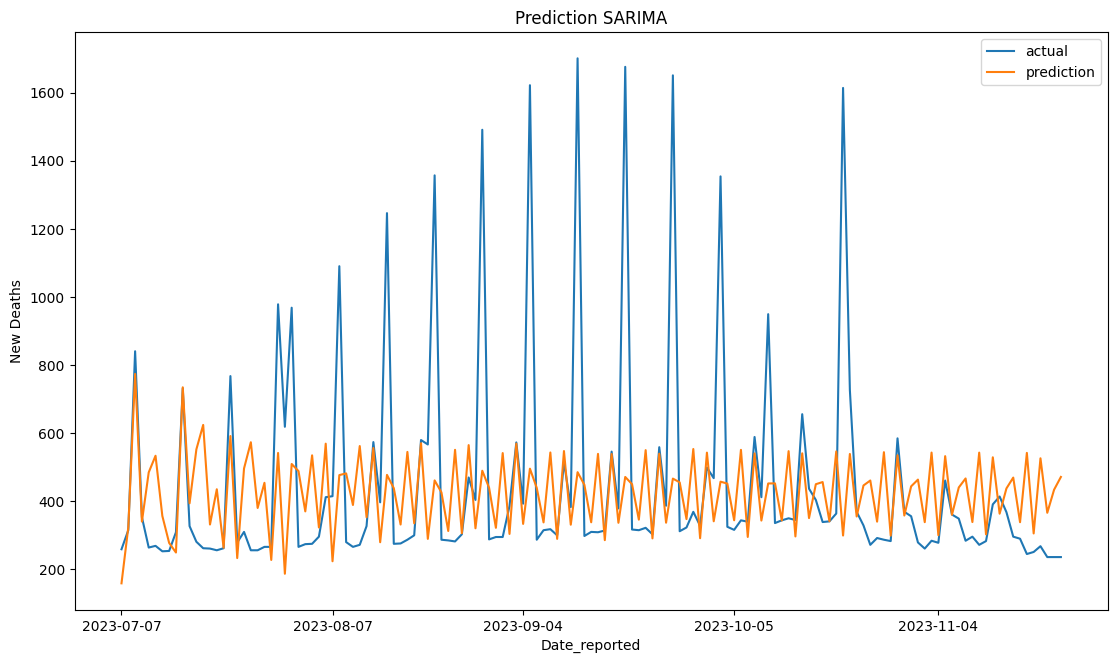

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(dates[int(data_length*train_split):], (test[target_column]-1).values, label="actual")
ax.plot(dates[int(data_length*train_split):], list(pred), label="prediction")
ax.set_title("Prediction SARIMA")
ax.set_ylabel("New Deaths")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

RMSE of the result

In [14]:
print_evaluation_metrics(non_zero, test[target_column]-1, train[target_column]-1)

Evaluation Metrics:
MSE: 103067.35
RMSE: 321.04
MAE: 186.65
MAPE: 38.92
SMAPE: 35.47
MASE: 0.11


In [9]:
store_model(model, "sarima")